# Exploratory Statistics: Hurricane analysis, part 2/3
> * 🔬 Data Science
* 🖥️ Computation-intensive operation, requires GeoAnalytics desktop tools
* 👟 Ready To Run!

Adapted from the [original sample notebook](https://www.arcgis.com/home/item.html?id=c3b498ad9f794c0d8d36679c3644dbb9) published under the same title by Esri in ArcGIS Online.

This is the second part to a three part set of notebooks that process and analyze historic hurricane tracks. In the previous notebook you completed the following steps:
 1. download historic hurricane datasets using Python
 2. clean and merge hurricane observations using Dask
 3. aggregated point observations into hurricane tracks using ArcGIS GeoAnalytics tools in ArcGIS Pro

In this notebook you will analyze the aggregated tracks to investigate the communities that are most affected by hurricanes, as well as as answer important questions about the prevalance of hurricanes, their seasonality, their density, and places where they make landfall.

*Note: if you would like to skip Part 1 of this series, and get started with the analysis in this notebook, you can extract the contents of the `hurricanes.gdb.part1.zip` archive included in the data folder - if a previous copy of `hurricanes.gdb` exists in your data folder, remove it before extracting the data.*

***Disclaimer:*** *the data processing and analyes presented in this notebook are for demonstration purposes only.*

<h1>**Table of Contents**<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Setup" data-toc-modified-id="Setup-1">Setup</a></span><ul class="toc-item"><li><span><a href="#Connect-to-ArcGIS-Online" data-toc-modified-id="Connect-to-ArcGIS-Online-1.1">Connect to ArcGIS Online</a></span></li><li><span><a href="#Setup-data-paths" data-toc-modified-id="Setup-data-paths-1.2">Setup data paths</a></span></li></ul></li><li><span><a href="#Access-aggregated-hurricane-data" data-toc-modified-id="Access-aggregated-hurricane-data-2">Access aggregated hurricane data</a></span><ul class="toc-item"><li><span><a href="#Load-the-hurricane-tracks-into-a-Spatially-Enabled-DataFrame" data-toc-modified-id="Load-the-hurricane-tracks-into-a-Spatially-Enabled-DataFrame-2.1">Load the hurricane tracks into a Spatially Enabled <code>DataFrame</code></a></span></li></ul></li><li><span><a href="#Exploratory-data-analysis" data-toc-modified-id="Exploratory-data-analysis-3">Exploratory data analysis</a></span><ul class="toc-item"><li><span><a href="#Does-the-number-of-hurricanes-increase-with-time?" data-toc-modified-id="Does-the-number-of-hurricanes-increase-with-time?-3.1">Does the number of hurricanes increase with time?</a></span></li><li><span><a href="#How-many-hurricanes-occure-per-basin-and-sub-basin?" data-toc-modified-id="How-many-hurricanes-occure-per-basin-and-sub-basin?-3.2">How many hurricanes occure per basin and sub basin?</a></span></li><li><span><a href="#Are-certain-hurricane-names-more-popular?" data-toc-modified-id="Are-certain-hurricane-names-more-popular?-3.3">Are certain hurricane names more popular?</a></span></li><li><span><a href="#Is-there-a-seasonality-in-the-occurrence-of-hurricanes?" data-toc-modified-id="Is-there-a-seasonality-in-the-occurrence-of-hurricanes?-3.4">Is there a seasonality in the occurrence of hurricanes?</a></span></li><li><span><a href="#What-percent-of-hurricanes-make-landfall?" data-toc-modified-id="What-percent-of-hurricanes-make-landfall?-3.5">What percent of hurricanes make landfall?</a></span></li><li><span><a href="#How-far-do-hurricanes-travel-inland-after-landfall?" data-toc-modified-id="How-far-do-hurricanes-travel-inland-after-landfall?-3.6">How far do hurricanes travel inland after landfall?</a></span></li><li><span><a href="#Where-do-hurricanes-make-landfall?" data-toc-modified-id="Where-do-hurricanes-make-landfall?-3.7">Where do hurricanes make landfall?</a></span></li><li><span><a href="#Perform-density-analysis-on-hurricane-landfall-locations" data-toc-modified-id="Perform-density-analysis-on-hurricane-landfall-locations-3.8">Perform density analysis on hurricane landfall locations</a></span></li><li><span><a href="#What-are-the-demographics-of-places-with-highest-density-of-landfalls?" data-toc-modified-id="What-are-the-demographics-of-places-with-highest-density-of-landfalls?-3.9">What are the demographics of places with highest density of landfalls?</a></span></li></ul></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-4">Conclusion</a></span></li></ul></div>

## Setup

Import the libraries necessary for this notebook.

In [1]:
# import ArcPy, ArcGIS Libraries
import arcpy
from arcgis.gis import GIS
from arcgis.geometry import filters
from arcgis.geocoding import geocode
from arcgis.features.manage_data import overlay_layers
from arcgis.geoenrichment import enrich

# import Pandas for data exploration
import pandas as pd
import numpy as np
from scipy import stats

# import plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# import display tools
from pprint import pprint
from IPython.display import display

# import system libs
import os
from sys import getsizeof

# Miscellaneous imports
import warnings
warnings.filterwarnings('ignore')

# Enable overwriting output
arcpy.env.overwriteOutput = True

### Connect to ArcGIS Online

You can substitute a different profile if you already have one created.  If you do not yet have a profile created, add your username as the second argument to the `GIS()` function.  You will be prompted for your password to initialize the connection.

You must connect with an account that has access to ArcGIS Online service credits and is able to use the geoenrichment service. 

In [2]:
gis = GIS('https://www.arcgis.com', profile="nbprofile")

### Setup data paths

*Note: update the `data_dir` path to point to the location where you extracted the files for this workshop.*

In [3]:
data_dir = 'D:/arcgis_notebooks/hurricane_analysis/data'
hurricanes_gdb = os.path.join(data_dir, "hurricanes.gdb")

## Access aggregated hurricane data
Below, you will access the tracks that were aggregated using GeoAnalytics tools in ArcGIS Pro in the previous notebook.

In [4]:
hurricane_tracks_fc = os.path.join(hurricanes_gdb, "hurricane_tracks")

The **GeoAnalytics** reconstruct tracks tools was used to calculate summary statistics of all numeric fields. However, only a few of the resulting columns are of interest for this tutorial.

In [5]:
pprint([f.name for f in arcpy.Describe(hurricane_tracks_fc).fields], compact=True, width=80)

['OBJECTID', 'Serial_Num', 'COUNT', 'COUNT_Season', 'SUM_Season', 'MEAN_Season',
 'MIN_Season', 'MAX_Season', 'SD_Season', 'VAR_Season', 'RANGE_Season',
 'COUNT_Num', 'SUM_Num', 'MEAN_Num', 'MIN_Num', 'MAX_Num', 'SD_Num', 'VAR_Num',
 'RANGE_Num', 'COUNT_Basin', 'ANY_Basin', 'COUNT_Sub_basin', 'ANY_Sub_basin',
 'COUNT_Name', 'ANY_Name', 'COUNT_ISO_time', 'ANY_ISO_time', 'COUNT_Nature',
 'ANY_Nature', 'COUNT_Center', 'ANY_Center', 'COUNT_Track_type',
 'ANY_Track_type', 'COUNT_Current_Basin', 'ANY_Current_Basin',
 'COUNT_latitude_merged', 'SUM_latitude_merged', 'MEAN_latitude_merged',
 'MIN_latitude_merged', 'MAX_latitude_merged', 'SD_latitude_merged',
 'VAR_latitude_merged', 'RANGE_latitude_merged', 'COUNT_longitude_merged',
 'SUM_longitude_merged', 'MEAN_longitude_merged', 'MIN_longitude_merged',
 'MAX_longitude_merged', 'SD_longitude_merged', 'VAR_longitude_merged',
 'RANGE_longitude_merged', 'COUNT_wind_merged', 'SUM_wind_merged',
 'MEAN_wind_merged', 'MIN_wind_merged', 'MAX_wind_merg

Below you will specify list of the names of fields that need to be kept for the rest of the analysis in this notebook.

In [6]:
fields_to_keep = ['OBJECTID', 'COUNT', 'MIN_Season', 'ANY_Basin', 'ANY_Sub_basin',
                  'ANY_Name', 'MEAN_latitude_merged', 'MEAN_longitude_merged', 
                  'MIN_wind_merged', 'RANGE_wind_merged', 'MIN_pressure_merged',
                  'RANGE_pressure_merged', 'MAX_eye_dia_merged', 'TRACK_DURATION',
                  'END_DATE', 'START_DATE']

fields_to_drop = [
    f.name for f in arcpy.Describe(hurricane_tracks_fc).fields if f.name not in fields_to_keep 
    and not f.name.lower().startswith("shape") 
]

### Load the hurricane tracks into a Spatially Enabled `DataFrame`

With the ArcGIS API for Python, you can easily load the tracks feature class into a new spatially enabled data frame:

In [7]:
all_hurricanes_sdf = pd.DataFrame.spatial.from_featureclass(hurricane_tracks_fc)

Select only the columns listed in `fields_to_keep`

In [8]:
all_hurricanes_sdf.drop(labels=fields_to_drop, axis=1, inplace=True)
all_hurricanes_sdf.shape

(12757, 17)

There are **`12,757`** hurricanes that were identified by GeoAnalytics reconstruct tracks tool. To get an preview of this aggregated dataset, call the `head()` method.

In [9]:
all_hurricanes_sdf.head()

OBJECTID  COUNT  MIN_Season ANY_Basin ANY_Sub_basin    ANY_Name  \
0         1   21.0        1848        SI            MM  XXXX848002   
1         2   59.0        1852        NA            NA     UNNAMED   
2         3    9.0        1853        NA            CS   NOT NAMED   
3         4   17.0        1853        NA            GM   NOT NAMED   
4         5   22.0        1853        NA            NA   NOT NAMED   

   MEAN_latitude_merged  MEAN_longitude_merged  MIN_wind_merged  \
0            -24.045952              51.730714              0.0   
1             25.289831             -63.489831             35.0   
2             18.644444             -79.400000             30.0   
3             27.488235             -87.164706             30.0   
4             32.350000             -59.686364             35.0   

   RANGE_wind_merged  MIN_pressure_merged  RANGE_pressure_merged  \
0                0.0                  0.0                    0.0   
1               55.0                  0.0                  948.0   
2               20.0                  NaN                    NaN   
3               15.0                  NaN                    NaN   
4               30.0                  NaN                    NaN   

   MAX_eye_dia_merged  TRACK_DURATION               START_DATE  \
0                 NaN    4.320000e+08  1848-01-11 06:00:00.000   
1                 0.0    1.252800e+09  1852-09-20 00:00:00.000   
2                 NaN    1.728000e+08  1853-08-25 12:00:00.000   
3                 NaN    3.456000e+08  1853-09-07 12:00:00.000   
4                 NaN    4.536000e+08  1853-09-24 12:00:00.000   

                  END_DATE                                              SHAPE  
0  1848-01-16 06:00:00.000  {'paths': [[[57.400000000000034, -15.199999999...  
1  1852-10-04 12:00:00.000  {'paths': [[[-50.599999999999966, 13.000000000...  
2  1853-08-27 12:00:00.000  {'paths': [[[-78.69999999999999, 17.6000000000...  
3  1853-09-11 12:00:00.000  {'paths': [[[-85.99999999999994, 23.8000000000...  
4  1853-09-29 18:00:00.000  {'paths': [[[-67.49999999999994, 26.5000000000...

To better analyze this data set over time, ensure the `START_DATE` and `END_DATE` columns are converted to datetime objects.  The `START_DATE` column will also be set as the index of the dataset.

In [10]:
all_hurricanes_sdf['START_DATE'] = pd.to_datetime(all_hurricanes_sdf['START_DATE'])
all_hurricanes_sdf['END_DATE'] = pd.to_datetime(all_hurricanes_sdf['END_DATE'])
all_hurricanes_sdf.index = all_hurricanes_sdf['START_DATE']
all_hurricanes_sdf.head()

OBJECTID  COUNT  MIN_Season ANY_Basin ANY_Sub_basin  \
START_DATE                                                                 
1848-01-11 06:00:00         1   21.0        1848        SI            MM   
1852-09-20 00:00:00         2   59.0        1852        NA            NA   
1853-08-25 12:00:00         3    9.0        1853        NA            CS   
1853-09-07 12:00:00         4   17.0        1853        NA            GM   
1853-09-24 12:00:00         5   22.0        1853        NA            NA   

                       ANY_Name  MEAN_latitude_merged  MEAN_longitude_merged  \
START_DATE                                                                     
1848-01-11 06:00:00  XXXX848002            -24.045952              51.730714   
1852-09-20 00:00:00     UNNAMED             25.289831             -63.489831   
1853-08-25 12:00:00   NOT NAMED             18.644444             -79.400000   
1853-09-07 12:00:00   NOT NAMED             27.488235             -87.164706   
1853-09-24 12:00:00   NOT NAMED             32.350000             -59.686364   

                     MIN_wind_merged  RANGE_wind_merged  MIN_pressure_merged  \
START_DATE                                                                     
1848-01-11 06:00:00              0.0                0.0                  0.0   
1852-09-20 00:00:00             35.0               55.0                  0.0   
1853-08-25 12:00:00             30.0               20.0                  NaN   
1853-09-07 12:00:00             30.0               15.0                  NaN   
1853-09-24 12:00:00             35.0               30.0                  NaN   

                     RANGE_pressure_merged  MAX_eye_dia_merged  \
START_DATE                                                       
1848-01-11 06:00:00                    0.0                 NaN   
1852-09-20 00:00:00                  948.0                 0.0   
1853-08-25 12:00:00                    NaN                 NaN   
1853-09-07 12:00:00                    NaN                 NaN   
1853-09-24 12:00:00                    NaN                 NaN   

                     TRACK_DURATION          START_DATE            END_DATE  \
START_DATE                                                                    
1848-01-11 06:00:00    4.320000e+08 1848-01-11 06:00:00 1848-01-16 06:00:00   
1852-09-20 00:00:00    1.252800e+09 1852-09-20 00:00:00 1852-10-04 12:00:00   
1853-08-25 12:00:00    1.728000e+08 1853-08-25 12:00:00 1853-08-27 12:00:00   
1853-09-07 12:00:00    3.456000e+08 1853-09-07 12:00:00 1853-09-11 12:00:00   
1853-09-24 12:00:00    4.536000e+08 1853-09-24 12:00:00 1853-09-29 18:00:00   

                                                                 SHAPE  
START_DATE                                                              
1848-01-11 06:00:00  {'paths': [[[57.400000000000034, -15.199999999...  
1852-09-20 00:00:00  {'paths': [[[-50.599999999999966, 13.000000000...  
1853-08-25 12:00:00  {'paths': [[[-78.69999999999999, 17.6000000000...  
1853-09-07 12:00:00  {'paths': [[[-85.99999999999994, 23.8000000000...  
1853-09-24 12:00:00  {'paths': [[[-67.49999999999994, 26.5000000000...

The track duration and length columns need to be projected to units (days, hours, miles) that are meaningful for analysis.

In [11]:
all_hurricanes_sdf['TRACK_DURATION_HRS'] = all_hurricanes_sdf['TRACK_DURATION'] / 3600000
all_hurricanes_sdf['TRACK_DURATION_DAYS'] = all_hurricanes_sdf['TRACK_DURATION'] / (3600000*24)

## Exploratory data analysis
In this section you will perform exploratory analysis of the dataset and answer some interesting questions.

To begin, create a map widget that you will use to vizualize a sample of the data:

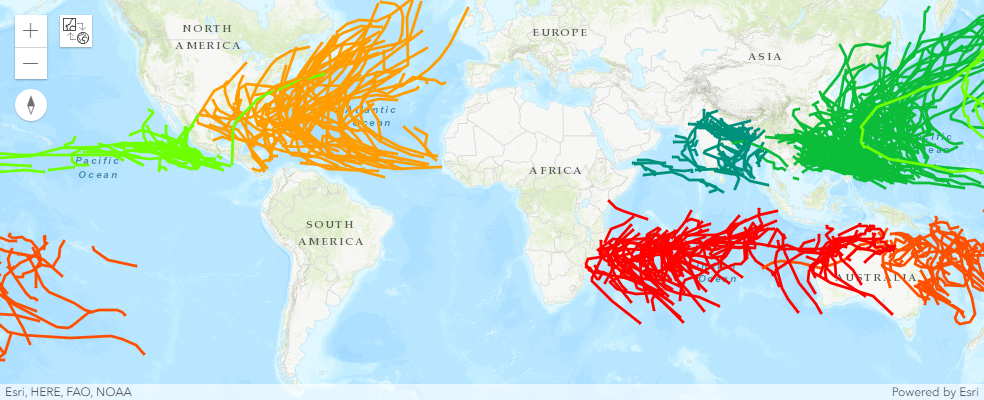

In [16]:
map1 = gis.map()
map1

Execute the cell below, and you will see drawn in the in the map above a set of `500` hurricanes chosen at random. You can visualize spatially enabled data frames using different types of renderers. In the example above a unique value renderer is applied on the **basin** column.

In the controls of the map, you may switch to 3D mode and view the same data on a globe.

In [17]:
all_hurricanes_sdf.sample(n=500, random_state=2).spatial.plot(
    map_widget=map1, renderer_type='u', col='ANY_Basin', cmap='prism'
)

True

If you prefer, you can control a map widget in the notebook to use `3D` mode by default:

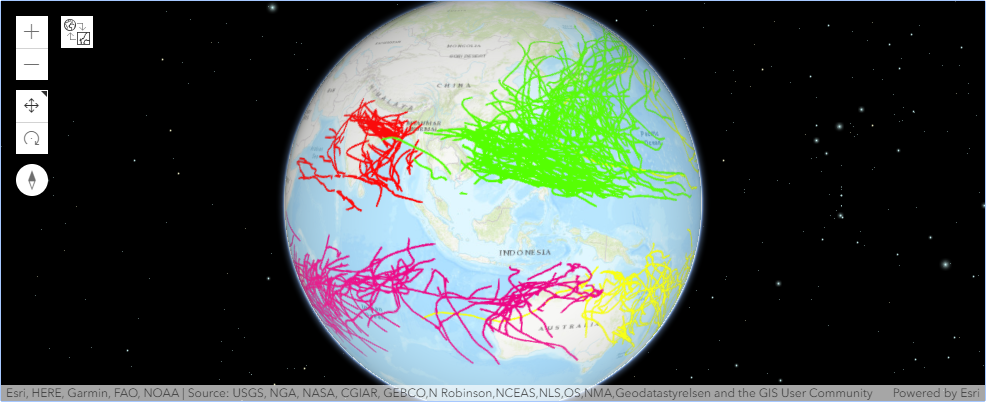

In [20]:
map2 = gis.map()
map2.mode= '3D'
map2

In [21]:
all_hurricanes_sdf.sample(n=500, random_state=2).spatial.plot(
    map_widget=map2, renderer_type='u', col='ANY_Basin', cmap='prism'
)

True

### Does the number of hurricanes increase with time?
To understand if number of hurricanes have increased over time, plot a histogram of the `MIN_Season` column:

Text(0.5, 1.0, 'Number of hurricanes recorded over time')

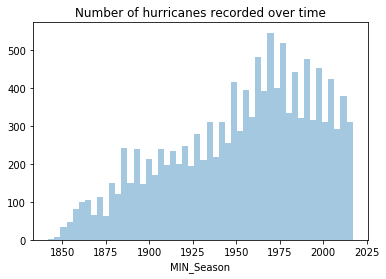

In [22]:
ax = sns.distplot(all_hurricanes_sdf['MIN_Season'], kde=False, bins=50)
ax.set_title('Number of hurricanes recorded over time')

The number of hurricanes recorded increases steadily until `1970`. This could be due to advances in geospatial technologies allowing scientists to better monitor hurricanes. However, after `1970` there is a noticable reduction in the number of hurricanes. This is in line with what [scientists observe and predict](https://www.nytimes.com/2018/10/10/climate/hurricane-michael-climate-change.html).

### How many hurricanes occure per basin and sub basin?
Climate scientists have organized global hurricanes into `7` basins and a number of sub basins. Execute the code cell below to group the data by basin and sub basin, count the occurrences, and plot the frequency in bar charts.

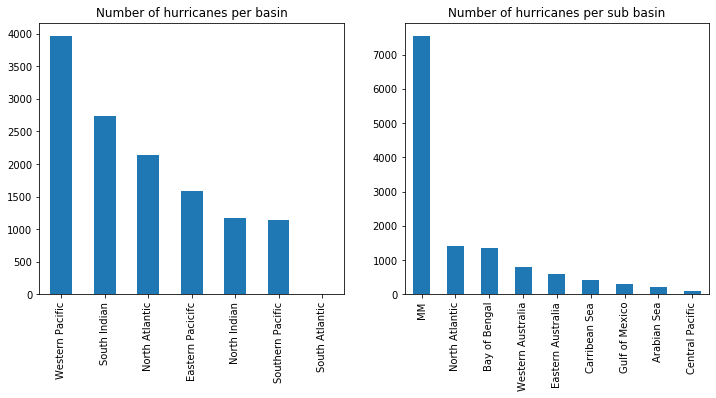

In [23]:
fig1, ax1 = plt.subplots(1,2, figsize=(12,5))

basin_ax = all_hurricanes_sdf['ANY_Basin'].value_counts().plot(kind='bar', ax=ax1[0])
basin_ax.set_title('Number of hurricanes per basin')
basin_ax.set_xticklabels(['Western Pacific', 'South Indian', 'North Atlantic',
                          'Eastern Pacicifc', 'North Indian','Southern Pacific',
                          'South Atlantic'])

sub_basin_ax = all_hurricanes_sdf['ANY_Sub_basin'].value_counts().plot(kind='bar', ax=ax1[1])
sub_basin_ax.set_title('Number of hurricanes per sub basin')
sub_basin_ax.set_xticklabels(['MM','North Atlantic','Bay of Bengal','Western Australia',
                            'Eastern Australia', 'Carribean Sea', 'Gulf of Mexico',
                            'Arabian Sea', 'Central Pacific'])
sub_basin_ax.tick_params()

Thus, most hurricanes occur in the **Western Pacific** basin. This is the region that is east of China, Phillipines and rest of South East Asia. This is followed by the **South Indian** basin which spans from west of Australia to east of Southern Africa. The **North Atlantic** basin which is the source of hurricanes in the continental United States ranks as the third busiest hurricane basin.

### Are certain hurricane names more popular?


Pandas provides a handy function called `value_counts()` to count unique occurrences. In the code cell below, you will use it to count the number of times each hurricane name has been used, and then print the top `30` most frequently used names.

In [24]:
# Get the number of occurrences of top 30 hurricane names
all_hurricanes_sdf['ANY_Name'].value_counts()[:30]

NOT NAMED          4116
UNNAMED            1408
06B                  31
09B                  30
04B                  30
05B                  30
07B                  29
10B                  29
08B                  29
03B                  28
01B                  27
12B                  26
11B                  23
13B                  23
02B                  22
14B                  17
IRMA                 17
SUBTROP:UNNAMED      16
JUNE                 15
FLORENCE             15
OLGA                 14
JUDY                 14
02A                  14
FREDA                14
LOLA                 14
THELMA               14
DOT                  14
KATE                 13
NINA                 13
AGNES                13
Name: ANY_Name, dtype: int64

Names like `IRMA`, `JUNE`, and `FLORENCE`. appear to be popular. Interestingly, all are of female gender. You can take this further to explore at what time periods have the name `IRMA` been used:

In [29]:
all_hurricanes_sdf[all_hurricanes_sdf['ANY_Name']=='JUNE'].sort_index().index

DatetimeIndex(['1958-09-20 00:00:00', '1958-09-20 00:00:00',
               '1961-08-01 00:00:00', '1964-08-09 00:00:00',
               '1966-09-18 18:00:00', '1969-10-26 00:00:00',
               '1972-09-24 00:00:00', '1975-11-15 00:00:00',
               '1981-06-15 00:00:00', '1984-08-25 00:00:00',
               '1986-02-05 00:00:00', '1987-09-27 06:00:00',
               '1997-04-27 18:00:00', '2014-01-16 12:00:00',
               '2014-01-19 00:00:00'],
              dtype='datetime64[ns]', name='START_DATE', freq=None)

The name `JUNE` has been used consistently since the 1950s, but most frequently during the 60s.

### Is there a seasonality in the occurrence of hurricanes?

Hurricanes happen when `Sea Surface Temperature` (SST) is warm. Solar incidence is one of the key factors affecting SST and this typically happens during summer months. However, summer happens during different months in northern and southern hemispheres. To visualize this seasonality, you need to group your data by month as well as by basin. The code cell below creates a multilevel index grouper using `pandas`.

In [30]:
# Create a grouper object
grouper = all_hurricanes_sdf.START_DATE.dt.month_name()

# use grouper along with basin name to create a multilevel groupby object
hurr_by_basin = all_hurricanes_sdf.groupby([grouper,'ANY_Basin'], as_index=True)
hurr_by_basin_month = hurr_by_basin.count()[['COUNT', 'MIN_pressure_merged']]
hurr_by_basin_month.head()

COUNT  MIN_pressure_merged
START_DATE ANY_Basin                            
April      EP             1                    1
           NA             5                    5
           NI            41                    5
           SI           243                  149
           SP           108                   84

Now, you can turn the index into columns for further processing.

In [31]:
# turn index into columns
hurr_by_basin_month.reset_index(inplace=True)
hurr_by_basin_month.drop('MIN_pressure_merged', axis=1, inplace=True)
hurr_by_basin_month.columns = ['month', 'basin', 'count']
hurr_by_basin_month.head()

month basin  count
0  April    EP      1
1  April    NA      5
2  April    NI     41
3  April    SI    243
4  April    SP    108

Now add the month column back, but this time you will help Pandas understand how to sort months in the correct chronological order.

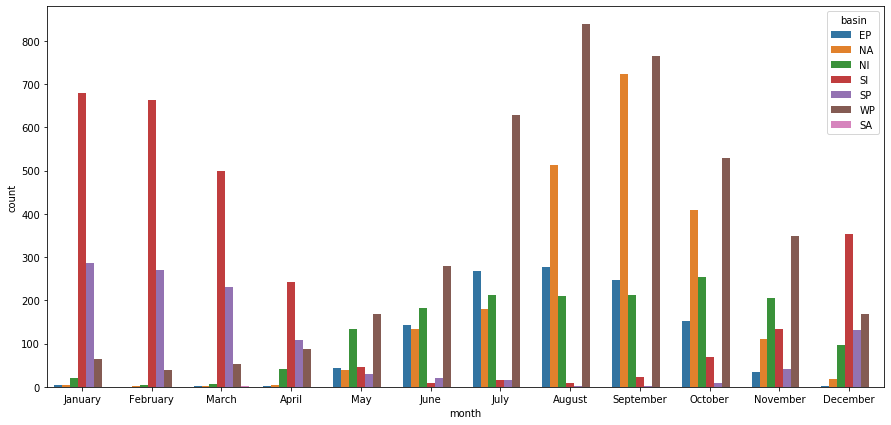

In [32]:
fig, ax = plt.subplots(1,1, figsize=(15,7))
month_order = ['January','February', 'March','April','May','June',
              'July','August','September','October','November','December']

sns.barplot(x='month', y='count', hue='basin', data=hurr_by_basin_month, ax=ax,
            order=month_order)

The bars in **red** represent the number of hurricanes in the **Sounth Indian** ocean, which spans from west of Australia to east of southern Africa. The **brown** bars are for the **Western Pacific** ocean, which spans east of China. The **orange** bars are for the **North Atlantic** ocean. The sinusoidal nature of these bars show the charateristic offset in summer between northern and southern hemispheres. The **green** bars represent **North Indian** hurricanes, which is dominated by the monsoon effect, and is seen to be prevalant for a longer span of months through the year, from May to December.

### What percent of hurricanes make landfall?
While exploring the hurricane data on maps, you noticed their geographic distribution and that they travel long distances over the oceans. You want to learn if all hurricanes eventually make landfall. If not, what percent of them do? This is an important question to answer as the threat to human life increases dramatically when a hurricane makes a landfall.

You will answer this question by performing **overlay analysis** using the corresponding tool from the ArcGIS Pro GeoAnalytics toolbox. For this, you need to intersect the hurricane tracks with a world boundary dataset. In the code cell below, you will make an anonymous connection to ArcGIS Online to look for a layer published by Esri in the Living Atlas.

In [33]:
agol_gis = GIS(set_active=False)
world_boundaries_item = agol_gis.content.get('57c1ade4fa7c4e2384e6a23f2b3bd254')
world_boundaries_item

<Item title:"World Continents" type:Feature Layer Collection owner:esri_dm>

You will first read thes features into a spatial data frame, then write them to a local feature class that can be used with the GeoAnalytics desktop tools.

In [34]:
world_boundaries_fl = world_boundaries_item.layers[0]
world_boundaries_sdf = pd.DataFrame.spatial.from_layer(world_boundaries_fl)

world_boundaries_fc = os.path.join(hurricanes_gdb, "world_boundaries")
world_boundaries_sdf.spatial.to_featureclass(world_boundaries_fc)

'D:\\arcgis_notebooks\\hurricane_analysis\\data\\hurricanes.gdb\\world_boundaries'

It is possible to use the [overlay](https://developers.arcgis.com/python/api-reference/arcgis.features.toc.html#arcgis.features.GeoAccessor.overlay) function to get the intersection of features in two spatially enabled data frames.  However, given the number of features you are working with, you will instead use the [overlay layers](https://pro.arcgis.com/en/pro-app/tool-reference/geoanalytics-desktop/overlay-layers.htm) GeoAnalytics tool to isolate the sections of hurricane tracks that intersect the land features represented in world boundaries polygon layer using the feature classes in the file geodatabase.

*Note: this operation may take a few minutes depending on the capacity of your machine.*

In [35]:
hurricane_landfall_tracks_fc = os.path.join(hurricanes_gdb, 'hurricane_landfall_tracks')

if os.path.exists(hurricane_landfall_tracks_fc):
    arcpy.management.Delete(hurricane_landfall_tracks_fc)

arcpy.gapro.OverlayLayers(
    input_layer=hurricane_tracks_fc, 
    overlay_layer=world_boundaries_fc, 
    out_feature_class=hurricane_landfall_tracks_fc,
    overlay_type="INTERSECT"
)

<Result 'D:\\arcgis_notebooks\\hurricane_analysis\\data\\hurricanes.gdb\\hurricane_landfall_tracks'>

Add an `ANALYSIS_LENGTH` column that you will use to store the geodesic distance in KM covered by each landfall track line segment:

In [36]:
arcpy.management.AddField(hurricane_landfall_tracks_fc, "ANALYSIS_LENGTH", "DOUBLE")
arcpy.management.CalculateGeometryAttributes(
    hurricane_landfall_tracks_fc,
    geometry_property="ANALYSIS_LENGTH LENGTH_GEODESIC",
    length_unit="KILOMETERS"
)

<Result 'D:/arcgis_notebooks/hurricane_analysis/data\\hurricanes.gdb\\hurricane_landfall_tracks'>

You can draw the resulting layer on a map to view those hurricanes that have made a landfall and traveled inland.

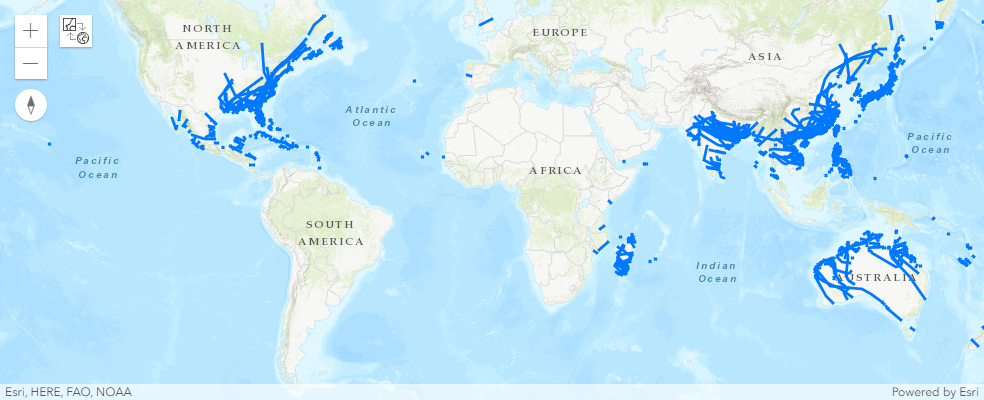

In [39]:
landfall_tracks_map = gis.map()
landfall_tracks_map

Load the landfall tracks layer into a Sptially Enabled DataFrame, and preview a random sample of its features.

In [40]:
landfall_tracks_sdf = pd.DataFrame.spatial.from_featureclass(hurricane_landfall_tracks_fc)
landfall_tracks_sdf.sample(n=500, random_state=2).spatial.plot(
    map_widget=landfall_tracks_map, symbol_type='simple', symbol_style='s'
)

True

Keep a subset of columns in the dataframe

In [41]:
fields_to_keep = ['MIN_Season', 'ANY_Basin','ANY_Name', 'MAX_wind_merged', 
                   'MIN_pressure_merged', 'TRACK_DURATION','END_DATE', 
                   'START_DATE', "ANALYSIS_LENGTH"]

fields_to_drop = [
    f for f in landfall_tracks_sdf.columns if f not in fields_to_keep 
    and not f.lower().startswith("shape") 
]

landfall_tracks_sdf.drop(labels=fields_to_drop, axis=1, inplace=True)
landfall_tracks_sdf.shape

(7683, 13)

In [42]:
landfall_tracks_sdf.head(3)

MIN_Season ANY_Basin                 ANY_Name  MAX_wind_merged  \
0        1998        NA                  GEORGES            135.0   
1        1994        SI  FARAH:PEARL:PEARL/FARAH             85.0   
2        1932        NI                NOT NAMED             30.0   

   MIN_pressure_merged  TRACK_DURATION               START_DATE  \
0                937.0    1.360800e+09  1998-09-15 12:00:00.000   
1                950.0    9.936000e+08  1994-01-10 06:00:00.000   
2                  NaN    6.264000e+08  1932-10-30 00:00:00.000   

                  END_DATE  Shape_Length_overlay   Shape__Area  Shape__Length  \
0  1998-10-01 06:00:00.000          5.951525e+08  1.113144e+14   5.951525e+08   
1  1994-01-21 18:00:00.000          2.996954e+07  9.652152e+12   2.996954e+07   
2  1932-11-06 06:00:00.000          3.111768e+08  1.145290e+14   3.111768e+08   

   ANALYSIS_LENGTH                                              SHAPE  
0      1693.634679  {'paths': [[[-69.26741809799995, 18.4269672390...  
1       100.610117  {'paths': [[[123.90000000000009, -17.099999999...  
2      1200.077887  {'paths': [[[82.74955952200008, 17.35827778200...

 Plot a bar chart showing the proportion of hurricanes in each basin that make a landfall.

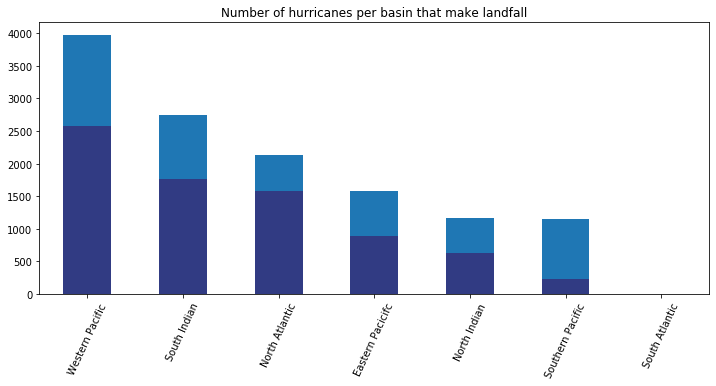

In [43]:
fig1, ax1 = plt.subplots(1,1, figsize=(12,5))

basin_ax = all_hurricanes_sdf['ANY_Basin'].value_counts().plot(kind='bar', ax=ax1)
basin_ax = landfall_tracks_sdf['ANY_Basin'].value_counts().plot(
    kind='bar', ax=ax1, cmap='viridis', alpha=0.5
)
basin_ax.set_title('Number of hurricanes per basin that make landfall')
basin_ax.tick_params(axis='x', labelrotation=65)
basin_ax.set_xticklabels(['Western Pacific', 'South Indian', 'North Atlantic',
                          'Eastern Pacicifc', 'North Indian','Southern Pacific',
                          'South Atlantic'])
basin_ax.tick_params()

The bar chart above plots the number of hurricane landfall tracks (per basin) another bar chart of the total number of hurricanes tracks per basin. From the chart, most hurricanes in the **Western Pacific**, **South Indian**, **North Atlantic** ocean make landfall. Hurricanes in the **Southern Pacific** ocean rarely make landfall. From this you can roughly guage the severity of hurricanes in different geographic basins.

### How far do hurricanes travel inland after landfall?
Hurricanes in general lose velocity and intensity after they make a landfall. Thus they can only travel a short distance inland. Using the `ANALYSIS_LENGTH` column created earlier, you can plot the histogram of that column to understand how far hurricanes have traveled inland after landfall.

Text(0.5, 0, 'Distance in KM')

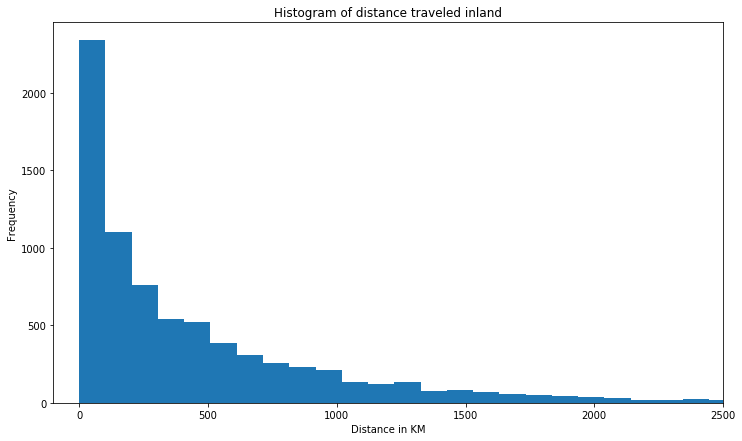

In [44]:
landfall_tracks_sdf['ANALYSIS_LENGTH'].plot(
    kind='hist', bins=100, title='Histogram of distance traveled inland', figsize=(12,7), xlim=[-100,2500]
)
plt.xlabel('Distance in KM')

The majority of hurricanes travel less than `500` km after making a landfall.

Execute the next code cell to find which are the top `50` hurricanes that have traveled longest inland.

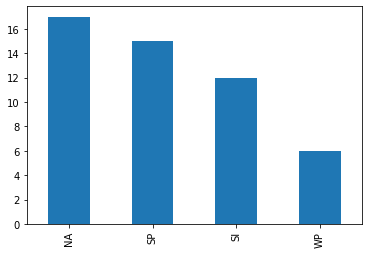

In [45]:
# filter the top 50 longest hurricanes (distance traveled inland)
top_50_longest = landfall_tracks_sdf.sort_values(by=['ANALYSIS_LENGTH'], axis=0, ascending=False).head(50)
top_50_longest['ANY_Basin'].value_counts().plot(kind='bar')

The **North Atlantic** basin, followed by the **Southern Pacific** and **South Indian** basins, contains hurricanes that have traveled the greatest distances inland.

By plotting this on the map, you will notice hurricanes have traveled longest inland over the east coast of North America, China and Australia. Interestingly, Australia bears landfall of hurricanes from both **South Indian** and **South Pacific** basins.

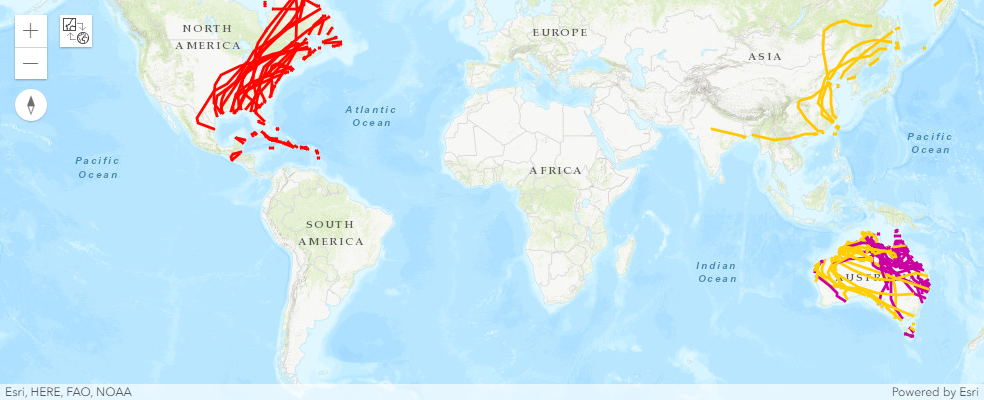

In [49]:
inland_map = gis.map()
inland_map

from IPython.display import Image
Image(filename="images/top50_landfall_tracks.png")

In [50]:
top_50_longest.spatial.plot(inland_map, renderer_type='u', col='ANY_Basin',cmap='prism')

True

### Where do hurricanes make landfall?
Of equal interest is finding where hurricanes make landfall. From experience, you likely know that certain regions are more prone to hurricane damage more than others. Using spatial data science, you can empirically derive those regions that have statistically more hurricane landfalls.

For this, you will first extract the starting vertex of each of the landfal line segments. Execute the next cell to use the [feature vertices to points](https://pro.arcgis.com/en/pro-app/tool-reference/data-management/feature-vertices-to-points.htm) tool to return the points along the coast lines where hurricanes made landfall by extracting the starting point of each landfall track.

In [51]:
hurricane_landfall_locations_fc = os.path.join(hurricanes_gdb, 'hurricane_landfall_locations')

if os.path.exists(hurricane_landfall_locations_fc):
    arcpy.management.Delete(hurricane_landfall_locations_fc)

arcpy.management.FeatureVerticesToPoints(
    in_features=hurricane_landfall_tracks_fc,
    out_feature_class=hurricane_landfall_locations_fc,
    point_location="START"
)

<Result 'D:\\arcgis_notebooks\\hurricane_analysis\\data\\hurricanes.gdb\\hurricane_landfall_locations'>

Vizualize these point locations in a map:

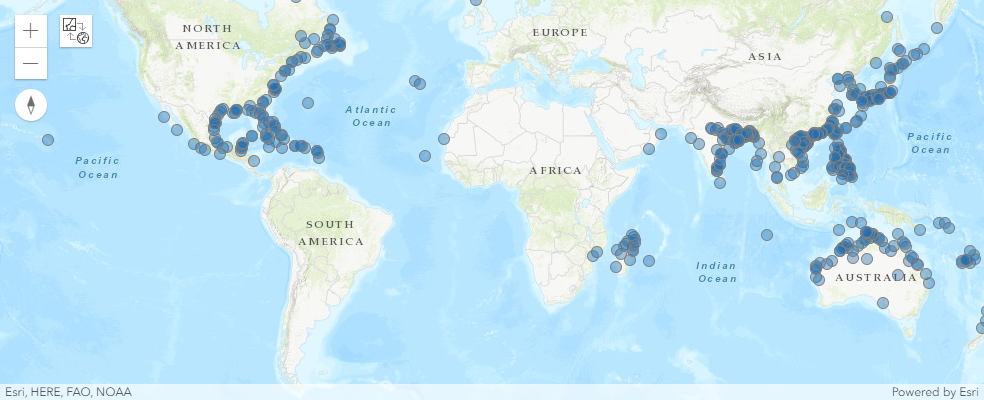

In [54]:
landfall_map = gis.map()
landfall_map

In [55]:
hurricane_landfall_locations_sdf = pd.DataFrame.spatial.from_featureclass(hurricane_landfall_locations_fc)
hurricane_landfall_locations_sdf.sample(n=500, random_state=2).spatial.plot(
    map_widget=landfall_map, cmap="Blues", alpha=0.4, line_width=0.5
)

True

### Perform density analysis on hurricane landfall locations
The map above shows a random sample from over 20 thousand points spread around the world. Do all these places have equal probability of being hit by a hurricane? To answer this, you can perform **density analysis**. The [Calculate Density](https://pro.arcgis.com/en/pro-app/tool-reference/geoanalytics-desktop/calculate-density.htm) tool available under the `Analyze Patterns` GeoAnalytics toolset in ArcGIS Pro can be used for this.

*Note: this analysis is being executed with a very coarse resolution to keep the number of features manageable for loading and visualizing the data plotted as graphics from spatially enabled data frames.  The result of this is that you will have cells that cover more than just immediately coastal areas in your analysis.  To get results that reflect the density of hurricane landfalls near coastal populations more accurately, you can re-run the `CalculateDensity` tool below using smaller bin and neighbourhood sizes.*  ***However,*** *if you try this, it's best to skip plotting the cells as graphics directly in a map widget, and instead pick out the top 40 or 50 cells with the highest densities to define the `high_density_landfalls` defined further below.  If you want to vizualize the entire layer, you can open it in ArcGIS Pro, or publish it as a feature layer in ArcGIS Online/Enterprise and add that to a map widget within the notebook.*

In [57]:
hurricane_landfall_density_fc = os.path.join(hurricanes_gdb, 'hurricane_landfall_density')

if os.path.exists(hurricane_landfall_density_fc):
    arcpy.management.Delete(hurricane_landfall_density_fc)

arcpy.gapro.CalculateDensity(
    input_layer=hurricane_landfall_locations_fc, 
    out_feature_class=hurricane_landfall_density_fc,
    bin_type="SQUARE",
    bin_size="25 Kilometers",
    weight="UNIFORM",
    neighborhood_size="50 Kilometers", 
    area_unit_scale_factor="SQUARE_KILOMETERS"
)

<Result 'D:\\arcgis_notebooks\\hurricane_analysis\\data\\hurricanes.gdb\\hurricane_landfall_density'>

In [58]:
hurricane_landfall_density_sdf = pd.DataFrame.spatial.from_featureclass(hurricane_landfall_density_fc)
hurricane_landfall_density_sdf.shape

(26347, 3)

You can visualize these data by plotting them in the map widget with a natural class breaks renderer applied to highlight areas with the highest density.

*Note: it may take a few minutes to execute following steps, because the landfall density spatially enabled data frame contains over 26 thousand polygons representing 25km x 25km cells.  In this tutorial, you will make use of the class breaks renderer that is generated by loading this layer in subsequent steps.*

*When plotting in-memory datasets from spatially enabled data frames, all of the features are converted to graphics and are loaded locally into the map widget in the notebook interface in the Web browser.  It will be slow to render a layer with ~26k polygons if you display the entire world.  If you define a map widget that is zoomed in to specific areas, then you will still be able to visualize the data with reasonable performance.*

*An alternative approach to plotting features as local graphics layers is to publish the data as a feature layer in ArcGIS Online or Enterprise.  When feature layers are added to a map widget in a notebook, they perform better because the data required to display the layer at the map's current extent and resolution are only loaded on-demand.*

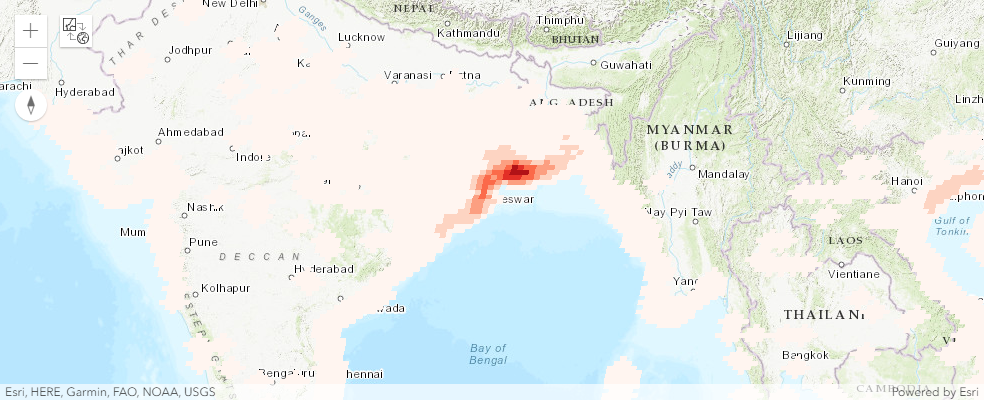

In [61]:
landfall_dens_map = gis.map("West Bengal", 5)
landfall_dens_map

In [62]:
hurricane_landfall_density_sdf.spatial.plot(
    map_widget=landfall_dens_map, cmap="Reds", line_width=0,
    renderer_type='c', method='esriClassifyNaturalBreaks', class_count=7, col="density"
)

True

The map here shows the computed kernel density of landfall locations. This was done by summing the number of landfalls within a radius of `50` km and dividing it by the area of this radius. Thus it spreads the number of landfalls over a smooth surface. In the display, you have classified this surface into `7` classes with the natural breaks reanderer.

Execute the next cells to extract these breaks from the layer info and assign a class to each feature, then use this class to plot a histogram.

In [63]:
cbs_list = []
cmap_list = []
class_breaks = landfall_dens_map.layers[0].layer.layerDefinition.drawingInfo.renderer.classBreakInfos
for cb in class_breaks:
    print(cb.description)  # print the class break labels
    cbs_list.append(cb.classMaxValue)
    cmap_list.append([x/255.0 for x in cb.symbol.color])

0.00012307692307692307 - 0.006543589743589743
0.006543589743589743 - 0.012964102564102565
0.012964102564102565 - 0.019384615384615386
0.019384615384615386 - 0.025805128205128206
0.025805128205128206 - 0.03222564102564102
0.03222564102564102 - 0.038646153846153844
0.038646153846153844 - 0.038646153846153844


Text(0.5, 1.0, 'Histogram of hurricane landfall density')

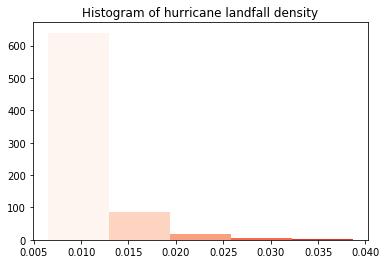

In [64]:
# build a histogram for the same class breaks
n, bins, patches = plt.hist(hurricane_landfall_density_sdf['density'], bins=cbs_list)

# apply the same color for each class to match the map
idx = 0
for c, p in zip(bins, patches):
    plt.setp(p, 'facecolor', cmap_list[idx])
    idx+=1

plt.title('Histogram of hurricane landfall density')

From the histogram above, you will notice there are very few places that can be classified as having a relatively high density of hurricane landfalls.

To analyze these places a bit further, select the locations having landfall densities within the top four class natural breaks classes:

In [65]:
high_density_landfalls = hurricane_landfall_density_sdf[hurricane_landfall_density_sdf['density'] >= cbs_list[2]]

high_density_landfalls.shape

(27, 3)

You have identified `27` areas worldwide that have a relatively high density of hurricane landfalls based on the anlaysis of data spanning the `176` year period. Below, you will plot these on two maps that focus on the most dense locations:

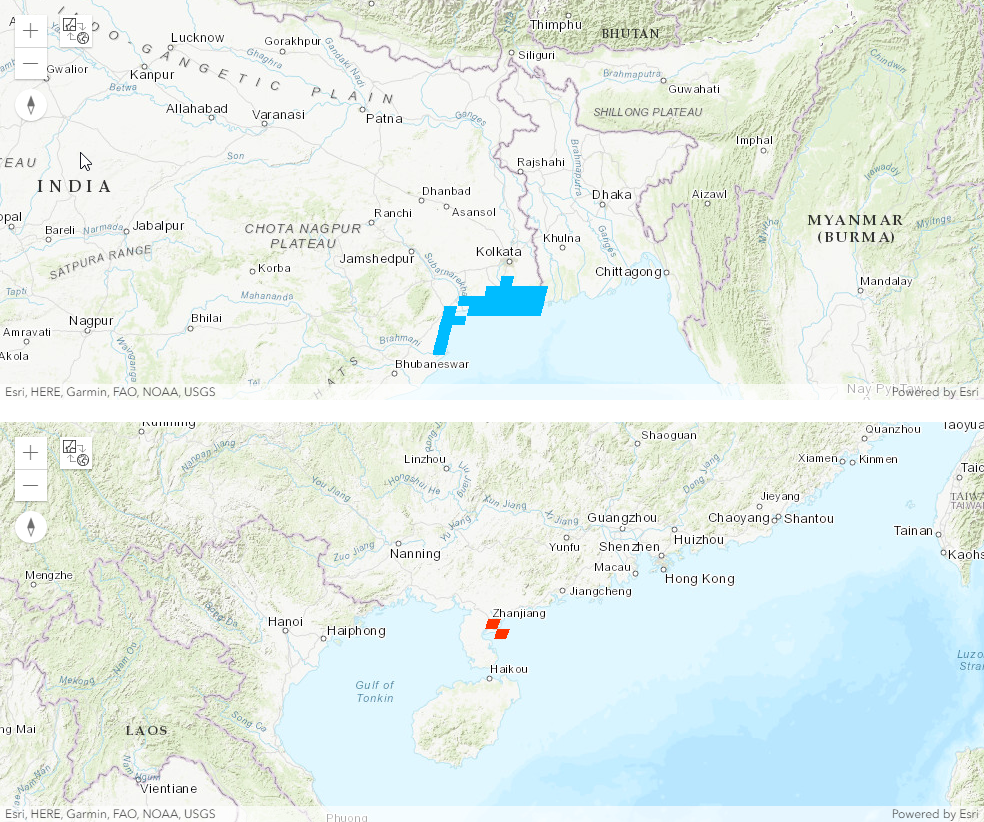

In [69]:
high_density_landfall_map1 = gis.map('West Bengal', 6)
high_density_landfall_map2 = gis.map('Zhanjiang, China', 6)
display(high_density_landfall_map1)
display(high_density_landfall_map2)

In [70]:
high_density_landfalls.spatial.plot(map_widget=high_density_landfall_map1, line_width=0, outline_color=0)
high_density_landfalls.spatial.plot(map_widget=high_density_landfall_map2, line_width=0, outline_color=0)

True

Here you can see two places that stand out,  located in the West Bengal area of **India**, and a small area along the south coast of **China**.

### What are the demographics of places with highest density of landfalls?
Now that you have found the places that have the highest desnity of landfalls, you may be faced with the question, who lives there? What is the impact of repeat natural calamities on these places? You can answer those questions by **geoenriching** the polygons with demographic and socio-economic attributes.

<blockquote>
    Note: Geoenrichment uses <a href="https://doc.arcgis.com/en/arcgis-online/administer/credits.htm#ESRI_SECTION1_709121D2C7694DCAB9B8592F36F7A5BA" target="_blank">ArcGIS Online credits</a> and requires you to be authenticated with an ArcGIS Online account that has permission to use geoenrichment.
</blockquote>

Execute the cell below to use the `enrich()` function imported from the `arcgis.geoenrichment` module to add socio-economic columns to the landfall density `DataFrame`. For a data collection, you can pick `keyGlobalFacts`, which is available for most parts of the world.

In [71]:
landfalls_enriched = enrich(high_density_landfalls, data_collections='keyGlobalFacts')
landfalls_enriched.head()

ID  OBJECTID_0 sourceCountry  OBJECTID   density  \
0  0           1            IN      1396  0.021169   
1  1           2            IN      1488  0.035077   
2  2           3            IN      6436  0.020185   
3  3           4            IN      7352  0.031877   
4  4           5            IN      8000  0.036185   

                    aggregationMethod  populationToPolygonSizeRating  \
0  BlockApportionment:IN.Subdistricts                          2.608   
1  BlockApportionment:IN.Subdistricts                          2.608   
2  BlockApportionment:IN.Subdistricts                          2.608   
3  BlockApportionment:IN.Subdistricts                          2.608   
4  BlockApportionment:IN.Subdistricts                          2.608   

   apportionmentConfidence  HasData   TOTPOP   TOTHH  AVGHHSZ  TOTMALES  \
0                    2.827        1   298296   60244     4.95    148813   
1                    2.827        1   357669   77761     4.60    182901   
2                    2.827        1  1090619  237099     4.60    557748   
3                    2.827        1   629134  136781     4.60    321720   
4                    2.827        0        0       0     0.00         0   

   TOTFEMALES                                              SHAPE  
0      149483  {'rings': [[[86.68178839621032, 20.65633375772...  
1      174768  {'rings': [[[88.0347857325701, 21.664281561660...  
2      532872  {'rings': [[[88.14965601834203, 22.06846954276...  
3      307414  {'rings': [[[88.36212594053502, 21.86630170053...  
4           0  {'rings': [[[88.5748797777055, 21.664281561660...

The `enrich()` operation accepts the Spatially Enabled `DataFrame`, performs spatial aggregation and returns another `DataFrame` with socio-economic and demographic columns added to it. The `data_collections` parameter decides which additional columns get added.

In the next code cell, you will visualize the population that is affected by country. For this, you will group by the `sourceCountry` column and sum up the results. The cell below plots the total number of males, females, and households that live within the high density polygons.

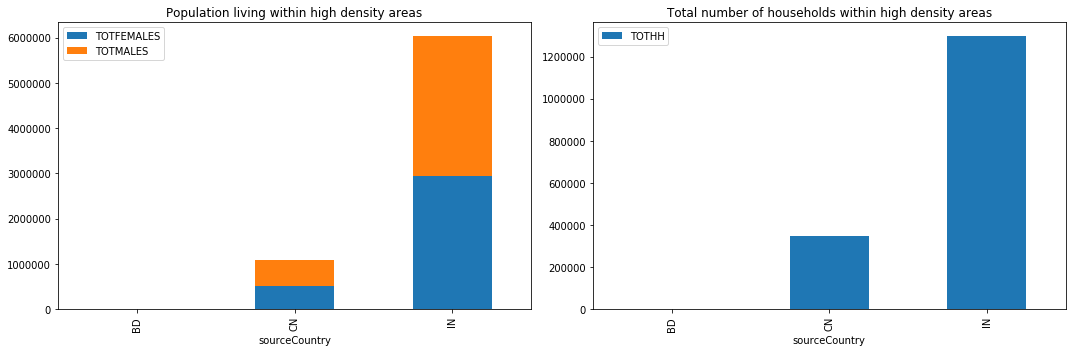

In [72]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
# plot bar chart 1
grouper1 = landfalls_enriched[['TOTFEMALES','TOTMALES','sourceCountry']].groupby(by='sourceCountry')
grouper1.sum().plot(kind='bar', stacked=True, ax=ax[0], 
                    title='Population living within high density areas')

# plot bar chart 2
grouper2 = landfalls_enriched[['TOTHH','sourceCountry']].groupby(by='sourceCountry')
grouper2.sum().plot(kind='bar', ax=ax[1], 
                    title='Total number of households within high density areas')

plt.tight_layout()

Hurricanes make landfalls on coasts, which invariably are places of dense population. By geoenriching the density maps, you are able to determine that the areas represented by the cells with the highest densities of hurricane landfalls contain about 6 million people in **India**, and about 1 million in **China**.  These areas are high risk as they suffer repeat landfalls and also support large populations.

Analyses such as these can be used inform government agences to imporove emergency preparedness for hurricane prone areas.

## Conclusion
In this notebook, you loaded the aggregated hurricane track data from Part 1 as a Spatially Enabled `DataFrame` object. You visualized these data both spatially and as charts to reveal interesting information about the global hurricane dataset.

You learned that global hurricanes are classified into `7` basins, with the most hurricanes occurring over the **Western Pacific** basin. The **North Atlantic** basin, which affects the continental United States, ranks as third busiest basin. The number of hurricanes recorded worldwide has been steadily climbing as technology improves. However, after the `1970`s, you observed a year-over-year reduction in the number of hurricanes. You will analyze more of this phenomena in the next part of this study.

As for hurricane names, the top spot found in the hurricane tracks was **IRMA**, with `17` occurrences over the `176` year period. By turning the `DataFrame` into a timeseries, you were able to observe a sinusoidal seasonality. The peaks between hurricanes in the northern hemisphere and cyclones in the southern hemisphere were offest by about `6` months, matching the time when summer occurs in these hemispheres. You also noticed that hurricanes over the **North Indian** basin occur over a longer period throughout the year as they are influenced by a monsoon phenomena.

You then performed **overlay analysis** to understand where hurricanes make landfall and the paths they take once they make landfall. You noticed that the majority of hurricanes make landfall. Once they make a landfall, the majority travel well under `500` KM inland. 

You extended the overlay analysis to calculate the specific points where landfalls occur. After performing a density analysis on the landfall locations, you found places along the coasts of **India** and **China** are affected most from a repeat landfall / historical perspective. 

By geo-enriching the high density places, you were able to understand the number of people that live in these places. In the areas you examined, **India** topped the list with the most people located in the areas you identified.

In the next notebook, you will extend this analysis to answer an important question: Does the intensity of hurricanes increase over time?